### installtions

In [1]:
# !pip install scikit-learn

### imports

In [42]:
import os
import time
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast, AdamW
# import datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.backends.cudnn as cudnn
from datetime import datetime
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

### paths & arguments

In [3]:
ROOT_PATH = os.getcwd()
DATA_PATH = os.path.join(ROOT_PATH, 'finetune_dataset/kge_sentiment_analysis')
# DATA_PATH = os.path.join(ROOT_PATH, '../../research_datasets/finetune_dataset/kge_sentiment_analysis')

# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
DATASET = 'SST5'
# DATASET = 'SST2'

BSZ = 64
EPOCH = 500
LR = 5e-6

# KOKONOMODEL = 'boomberta'
KOKONOMODEL = 'roberta'

KOKONOTEST = '_D_' + DATASET + '_M_' + KOKONOMODEL + '_B_' + str(BSZ) + '_E_' + str(EPOCH) + '_LR_' + str(LR)
print(KOKONOTEST)

_D_SST5_M_roberta_B_8_E_5_LR_1e-06


In [5]:
MODEL_NAME = 'roberta-large'

### some function for checking

In [6]:
def get_encodings_df_tokensaru(encodings, idx):
    ids, tokens, attention_mask = [], [], []
    i = 0

    for get_ids in encodings[idx].ids:
        ids += [get_ids]
        
    for get_tokens in encodings[idx].tokens:
        tokens += [get_tokens.replace('Ġ', '')]

    for get_attention_mask in encodings[idx].attention_mask:
        attention_mask += [get_attention_mask]
        i = i+1

    show_tokens_DF = pd.DataFrame({'ids': ids, 'tokens': tokens, 'attention_mask': attention_mask})
    print('got ' + str(i))
    return show_tokens_DF

In [7]:
# show_tokens_DF = get_encodings_df_tokensaru(test_encodings, 99)
# show_tokens_DF

In [8]:
def get_encodings_df(encodings, idx):
    input_ids, attention_mask = [], []
    i = 0

    for get_input_ids in encodings['input_ids'][idx]:
        input_ids += [get_input_ids]

    for get_attention_mask in encodings['attention_mask'][idx]:
        attention_mask += [get_attention_mask]
        i = i+1

    show_tokens_DF = pd.DataFrame({'input_ids': input_ids, 'attention_mask': attention_mask})
    print('got ' + str(i))
    return show_tokens_DF

In [9]:
# show_tokens_DF = get_encodings_df(test_encodings, 99)
# show_tokens_DF

In [10]:
def print_model_summary(model):
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            total_params += param.numel()
    print(f"Total Trainable Parameters: {total_params}")

In [11]:
# print_model_summary(model)

### datasets & preprocess

In [12]:
# # Load the SST-5 dataset
dataset = pd.read_csv(DATA_PATH + '/train.tsv.zip', sep="\t")
train, valid = train_test_split(dataset, random_state=42, test_size = 0.1)

In [13]:
# train, _ = train_test_split(train, random_state=42, test_size = 0.999)
# valid, _ = train_test_split(valid, random_state=42, test_size = 0.99)

In [14]:
# Load the tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)

# Tokenize the dataset
def tokenize_dataset(dataset):
    encodings = tokenizer(dataset['Phrase'].tolist(), truncation=True, padding=True)
    labels = dataset['Sentiment'].tolist()
    return encodings, labels

train_encodings, train_labels = tokenize_dataset(train)
valid_encodings, valid_labels = tokenize_dataset(valid)

In [15]:
# Create a torch dataset
class TsvDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item = {}
        item['input_ids'] = torch.tensor(self.encodings['input_ids'][idx])
        item['attention_mask'] = torch.tensor(self.encodings['attention_mask'][idx])
        item['labels'] = torch.tensor(self.labels[idx])

        return item

    def __len__(self):
        return len(self.labels)

In [16]:
train_dataset = TsvDataset(train_encodings, train_labels)
valid_dataset = TsvDataset(valid_encodings, valid_labels)

train_loader = DataLoader(train_dataset, batch_size=BSZ, shuffle=True, drop_last=True, generator=torch.Generator(device='cuda'))
valid_loader = DataLoader(valid_dataset, batch_size=BSZ, shuffle=True, drop_last=True, generator=torch.Generator(device='cuda'))

### boomberta import

In [17]:
import math
from typing import List, Optional, Tuple, Union

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

# from ...activations import ACT2FN, gelu
from transformers.activations import ACT2FN, gelu
# from ...modeling_outputs import (
#     BaseModelOutputWithPastAndCrossAttentions,
#     BaseModelOutputWithPoolingAndCrossAttentions,
#     CausalLMOutputWithCrossAttentions,
#     MaskedLMOutput,
#     MultipleChoiceModelOutput,
#     QuestionAnsweringModelOutput,
#     SequenceClassifierOutput,
#     TokenClassifierOutput,
# )
from transformers.modeling_outputs import (
    BaseModelOutputWithPastAndCrossAttentions,
    BaseModelOutputWithPoolingAndCrossAttentions,
    CausalLMOutputWithCrossAttentions,
    MaskedLMOutput,
    MultipleChoiceModelOutput,
    QuestionAnsweringModelOutput,
    SequenceClassifierOutput,
    TokenClassifierOutput,
)
# from ...modeling_utils import PreTrainedModel
from transformers.modeling_utils import PreTrainedModel
# from ...pytorch_utils import apply_chunking_to_forward, find_pruneable_heads_and_indices, prune_linear_layer
from transformers.pytorch_utils import apply_chunking_to_forward, find_pruneable_heads_and_indices, prune_linear_layer
# from ...utils import (
#     add_code_sample_docstrings,
#     add_start_docstrings,
#     add_start_docstrings_to_model_forward,
#     logging,
#     replace_return_docstrings,
# )
from transformers.utils import (
    add_code_sample_docstrings,
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    logging,
    replace_return_docstrings,
)
# from .configuration_roberta import RobertaConfig
from transformers.models.roberta.configuration_roberta import RobertaConfig

logger = logging.get_logger(__name__)

_CHECKPOINT_FOR_DOC = "roberta-base"
_CONFIG_FOR_DOC = "RobertaConfig"

ROBERTA_PRETRAINED_MODEL_ARCHIVE_LIST = [
    "roberta-base",
    "roberta-large",
    "roberta-large-mnli",
    "distilroberta-base",
    "roberta-base-openai-detector",
    "roberta-large-openai-detector",
    # See all RoBERTa models at https://huggingface.co/models?filter=roberta
]

ROBERTA_INPUTS_DOCSTRING = r"""
    Args:
        input_ids (`torch.LongTensor` of shape `({0})`):
            Indices of input sequence tokens in the vocabulary.

            Indices can be obtained using [`AutoTokenizer`]. See [`PreTrainedTokenizer.encode`] and
            [`PreTrainedTokenizer.__call__`] for details.

            [What are input IDs?](../glossary#input-ids)
        attention_mask (`torch.FloatTensor` of shape `({0})`, *optional*):
            Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.

            [What are attention masks?](../glossary#attention-mask)
        token_type_ids (`torch.LongTensor` of shape `({0})`, *optional*):
            Segment token indices to indicate first and second portions of the inputs. Indices are selected in `[0,1]`:

            - 0 corresponds to a *sentence A* token,
            - 1 corresponds to a *sentence B* token.
            This parameter can only be used when the model is initialized with `type_vocab_size` parameter with value
            >= 2. All the value in this tensor should be always < type_vocab_size.

            [What are token type IDs?](../glossary#token-type-ids)
        position_ids (`torch.LongTensor` of shape `({0})`, *optional*):
            Indices of positions of each input sequence tokens in the position embeddings. Selected in the range `[0,
            config.max_position_embeddings - 1]`.

            [What are position IDs?](../glossary#position-ids)
        head_mask (`torch.FloatTensor` of shape `(num_heads,)` or `(num_layers, num_heads)`, *optional*):
            Mask to nullify selected heads of the self-attention modules. Mask values selected in `[0, 1]`:

            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.

        inputs_embeds (`torch.FloatTensor` of shape `({0}, hidden_size)`, *optional*):
            Optionally, instead of passing `input_ids` you can choose to directly pass an embedded representation. This
            is useful if you want more control over how to convert `input_ids` indices into associated vectors than the
            model's internal embedding lookup matrix.
        output_attentions (`bool`, *optional*):
            Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
            tensors for more detail.
        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
"""

In [18]:
from transformers.models.roberta.modeling_roberta import (
    RobertaAttention, 
    RobertaPreTrainedModel, 
    RobertaPooler, 
    RobertaEmbeddings, 
    RobertaClassificationHead
    )
from torch import Tensor

In [19]:
class GELU(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(1.702 * x)

In [20]:
class Boom_crop(nn.Module):
    def __init__(self, in_features: int, out_features: int) -> None:
        super(Boom_crop, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

    def forward(self, input: Tensor) -> Tensor:
        ninp = self.out_features
        output = torch.narrow(input, -1, 0, input.shape[-1] // ninp * ninp)
        output = output.view(*output.shape[:-1], output.shape[-1] // ninp, ninp)
        output = output.sum(dim=-2)
        return output

In [21]:
class Boom_Layer(nn.Module):
    def __init__(self, in_features: int, mid_features: int, dropout=0.1) -> None:
        super(Boom_Layer, self).__init__()

        self.boom_crop = Boom_crop(in_features, mid_features)

        self.up_linear = nn.Linear(mid_features, in_features)
        self.act = GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, input: Tensor) -> Tensor:

        output = self.boom_crop(input)
        output = self.up_linear(output)
        output += input
        output = self.act(output)
        output = self.dropout(output)

        return output

In [22]:
class RobertaIntermediateAndBoom(nn.Module):
    def __init__(self, config):
        super().__init__()
        # self.dense_1 = nn.Linear(config.hidden_size, config.intermediate_size)
        # if isinstance(config.hidden_act, str):
        #     self.intermediate_act_fn = ACT2FN[config.hidden_act]
        # else:
        #     self.intermediate_act_fn = config.hidden_act

        # self.dense_2 = nn.Linear(config.intermediate_size, config.hidden_size)

        self.boom = Boom_Layer(config.hidden_size, config.intermediate_size)

        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        # hidden_states = self.dense_1(input_tensor)
        # hidden_states = self.intermediate_act_fn(hidden_states)

        # hidden_states = self.dense_2(hidden_states)

        hidden_states = self.boom(input_tensor)

        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)

        return hidden_states

In [23]:
class ModifiedRobertaLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.chunk_size_feed_forward = config.chunk_size_feed_forward
        self.seq_len_dim = 1
        self.attention = RobertaAttention(config)
        self.is_decoder = config.is_decoder
        self.add_cross_attention = config.add_cross_attention
        if self.add_cross_attention:
            if not self.is_decoder:
                raise ValueError(f"{self} should be used as a decoder model if cross attention is added")
            self.crossattention = RobertaAttention(config, position_embedding_type="absolute")
        # self.intermediate = RobertaIntermediate(config)#####
        # self.output = RobertaOutput(config)#####
        
        self.intermediateandboom = RobertaIntermediateAndBoom(config)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        self_attention_outputs = self.attention(
            hidden_states,
            attention_mask,
            head_mask,
            output_attentions=output_attentions,
            past_key_value=self_attn_past_key_value,
        )
        attention_output = self_attention_outputs[0]

        # if decoder, the last output is tuple of self-attn cache
        if self.is_decoder:
            outputs = self_attention_outputs[1:-1]
            present_key_value = self_attention_outputs[-1]
        else:
            outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights

        cross_attn_present_key_value = None
        if self.is_decoder and encoder_hidden_states is not None:
            if not hasattr(self, "crossattention"):
                raise ValueError(
                    f"If `encoder_hidden_states` are passed, {self} has to be instantiated with cross-attention layers"
                    " by setting `config.add_cross_attention=True`"
                )

            # cross_attn cached key/values tuple is at positions 3,4 of past_key_value tuple
            cross_attn_past_key_value = past_key_value[-2:] if past_key_value is not None else None
            cross_attention_outputs = self.crossattention(
                attention_output,
                attention_mask,
                head_mask,
                encoder_hidden_states,
                encoder_attention_mask,
                cross_attn_past_key_value,
                output_attentions,
            )
            attention_output = cross_attention_outputs[0]
            outputs = outputs + cross_attention_outputs[1:-1]  # add cross attentions if we output attention weights

            # add cross-attn cache to positions 3,4 of present_key_value tuple
            cross_attn_present_key_value = cross_attention_outputs[-1]
            present_key_value = present_key_value + cross_attn_present_key_value

        layer_output = apply_chunking_to_forward(
            self.feed_forward_chunk, self.chunk_size_feed_forward, self.seq_len_dim, attention_output
        )
        outputs = (layer_output,) + outputs

        # if decoder, return the attn key/values as the last output
        if self.is_decoder:
            outputs = outputs + (present_key_value,)

        return outputs

    def feed_forward_chunk(self, attention_output):
        # print(attention_output.shape)
        # intermediate_output = self.intermediate(attention_output)
        # print(intermediate_output.shape)
        # layer_output = self.output(intermediate_output, attention_output)
        # print(layer_output.shape)

        layer_output = self.intermediateandboom(attention_output)

        return layer_output

In [24]:
class ModifiedRobertaEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.layer = nn.ModuleList([ModifiedRobertaLayer(config) for _ in range(config.num_hidden_layers)])
        self.gradient_checkpointing = False

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = False,
        output_hidden_states: Optional[bool] = False,
        return_dict: Optional[bool] = True,
    ) -> Union[Tuple[torch.Tensor], BaseModelOutputWithPastAndCrossAttentions]:
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None
        all_cross_attentions = () if output_attentions and self.config.add_cross_attention else None

        next_decoder_cache = () if use_cache else None
        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None
            past_key_value = past_key_values[i] if past_key_values is not None else None

            if self.gradient_checkpointing and self.training:
                if use_cache:
                    logger.warning(
                        "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                    )
                    use_cache = False

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, past_key_value, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                )
            else:
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    past_key_value,
                    output_attentions,
                )

            hidden_states = layer_outputs[0]
            if use_cache:
                next_decoder_cache += (layer_outputs[-1],)
            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)
                if self.config.add_cross_attention:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[2],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    next_decoder_cache,
                    all_hidden_states,
                    all_self_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_decoder_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
            cross_attentions=all_cross_attentions,
        )

In [25]:
class ModifiedRobertaModel(RobertaPreTrainedModel):
    """

    The model can behave as an encoder (with only self-attention) as well as a decoder, in which case a layer of
    cross-attention is added between the self-attention layers, following the architecture described in *Attention is
    all you need*_ by Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz
    Kaiser and Illia Polosukhin.

    To behave as an decoder the model needs to be initialized with the `is_decoder` argument of the configuration set
    to `True`. To be used in a Seq2Seq model, the model needs to initialized with both `is_decoder` argument and
    `add_cross_attention` set to `True`; an `encoder_hidden_states` is then expected as an input to the forward pass.

    .. _*Attention is all you need*: https://arxiv.org/abs/1706.03762

    """

    _keys_to_ignore_on_load_missing = [r"position_ids"]

    # Copied from transformers.models.bert.modeling_bert.BertModel.__init__ with Bert->Roberta
    def __init__(self, config, add_pooling_layer=True):
        super().__init__(config)
        self.config = config

        self.embeddings = RobertaEmbeddings(config)
        self.encoder = ModifiedRobertaEncoder(config)

        self.pooler = RobertaPooler(config) if add_pooling_layer else None

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.embeddings.word_embeddings

    def set_input_embeddings(self, value):
        self.embeddings.word_embeddings = value

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    @add_start_docstrings_to_model_forward(ROBERTA_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    @add_code_sample_docstrings(
        checkpoint=_CHECKPOINT_FOR_DOC,
        output_type=BaseModelOutputWithPoolingAndCrossAttentions,
        config_class=_CONFIG_FOR_DOC,
    )
    # Copied from transformers.models.bert.modeling_bert.BertModel.forward
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], BaseModelOutputWithPoolingAndCrossAttentions]:
        r"""
        encoder_hidden_states  (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
            Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention if
            the model is configured as a decoder.
        encoder_attention_mask (`torch.FloatTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Mask to avoid performing attention on the padding token indices of the encoder input. This mask is used in
            the cross-attention if the model is configured as a decoder. Mask values selected in `[0, 1]`:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.
        past_key_values (`tuple(tuple(torch.FloatTensor))` of length `config.n_layers` with each tuple having 4 tensors of shape `(batch_size, num_heads, sequence_length - 1, embed_size_per_head)`):
            Contains precomputed key and value hidden states of the attention blocks. Can be used to speed up decoding.

            If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those that
            don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of all
            `decoder_input_ids` of shape `(batch_size, sequence_length)`.
        use_cache (`bool`, *optional*):
            If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding (see
            `past_key_values`).
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if self.config.is_decoder:
            use_cache = use_cache if use_cache is not None else self.config.use_cache
        else:
            use_cache = False

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        batch_size, seq_length = input_shape
        device = input_ids.device if input_ids is not None else inputs_embeds.device

        # past_key_values_length
        past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

        if attention_mask is None:
            attention_mask = torch.ones(((batch_size, seq_length + past_key_values_length)), device=device)

        if token_type_ids is None:
            if hasattr(self.embeddings, "token_type_ids"):
                buffered_token_type_ids = self.embeddings.token_type_ids[:, :seq_length]
                buffered_token_type_ids_expanded = buffered_token_type_ids.expand(batch_size, seq_length)
                token_type_ids = buffered_token_type_ids_expanded
            else:
                token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask: torch.Tensor = self.get_extended_attention_mask(attention_mask, input_shape)

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if self.config.is_decoder and encoder_hidden_states is not None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            if encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)
            encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

        embedding_output = self.embeddings(
            input_ids=input_ids,
            position_ids=position_ids,
            token_type_ids=token_type_ids,
            inputs_embeds=inputs_embeds,
            past_key_values_length=past_key_values_length,
        )
        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_extended_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None

        if not return_dict:
            return (sequence_output, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPoolingAndCrossAttentions(
            last_hidden_state=sequence_output,
            pooler_output=pooled_output,
            past_key_values=encoder_outputs.past_key_values,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
            cross_attentions=encoder_outputs.cross_attentions,
        )

In [26]:
class ModifiedRobertaForSequenceClassification(RobertaPreTrainedModel):
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.roberta = ModifiedRobertaModel(config, add_pooling_layer=False)
        self.classifier = RobertaClassificationHead(config)

        # Initialize weights and apply final processing
        self.post_init()

    @add_start_docstrings_to_model_forward(ROBERTA_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    @add_code_sample_docstrings(
        checkpoint="cardiffnlp/twitter-roberta-base-emotion",
        output_type=SequenceClassifierOutput,
        config_class=_CONFIG_FOR_DOC,
        expected_output="'optimism'",
        expected_loss=0.08,
    )
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = outputs[0]
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

### model

In [27]:
print(KOKONOMODEL)

roberta


In [28]:
if KOKONOMODEL == 'roberta':
    model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5)
elif KOKONOMODEL == 'boomberta':
    model = ModifiedRobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should 

In [29]:
print_model_summary(model)

Total Trainable Parameters: 355364869


In [30]:
for param in model.roberta.embeddings.parameters():
    param.requires_grad = False

for i in range(len(model.roberta.encoder.layer)):
    for param in model.roberta.encoder.layer[i].attention.parameters():
        param.requires_grad = False

In [31]:
print_model_summary(model)

Total Trainable Parameters: 202553349


### training

In [32]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model, train_loader, valid_loader, num_epochs, lr, device=torch.device("cuda:0")):
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        cudnn.benchmark = True
        self.best_loss = float("inf")
        self.phases = ["train", "valid"]

        self.device = device
        self.dataloaders = {self.phases[0]: train_loader, self.phases[1]: valid_loader}
    
        self.lr = lr
        self.num_epochs = num_epochs
        # self.accumulation_steps = 32 // self.dataloaders['train'].batch_size
        
        self.model = model.to(self.device)
        self.optimizer = AdamW(model.parameters(), lr=1e-5)
        # self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        
        self.losses =   {phase: [] for phase in self.phases}
        self.accuracy = {phase: [] for phase in self.phases}

    def iterate(self, epoch, phase):
        step_loss = []
        step_acc = []
        nowtime = time.strftime("%H:%M:%S")

        if phase == "train":
            self.model.train()
        else:
            self.model.eval()
        dataloader = self.dataloaders[phase]
        # running_losses = []
        # total_batches = len(dataloader)

        self.optimizer.zero_grad()
        pbar = tqdm(dataloader, total=len(dataloader), position=0, leave=True, desc=f"[{nowtime}] type: {phase} epoch {epoch}")
        for itr, batch in enumerate(pbar):
            batch = {key: value.to(self.device) for key, value in batch.items()}
            outputs = self.model(**batch)
            loss = outputs.loss

            if phase == "train":
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()

            # loss = loss / self.accumulation_steps
            # if phase == "train":
            #     loss.backward()
            #     if (itr + 1 ) % self.accumulation_steps == 0:
            #         self.optimizer.step()
            #         self.optimizer.zero_grad()

            step_loss += [loss.item()]

            _, predictions = outputs['logits'].max(1)
            label = batch['labels']
            step_acc += [(((predictions == label).sum())/(predictions.size(0))).item()]

        # epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        
        self.losses[phase] = self.losses[phase] + step_loss
        self.accuracy[phase] = self.accuracy[phase] + step_acc

        epoch_loss = sum(step_loss)/len(step_loss)
        epoch_accuracy = sum(step_acc)/len(step_acc)

        print("avg_loss: %0.4f | avg_acc: %0.4f" % (epoch_loss, epoch_accuracy))

        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.model.state_dict(),
                "optimizer": self.optimizer.state_dict(),
                'model': model,
            }

            valid_loss = self.iterate(epoch, "valid")
            # self.scheduler.step(valid_loss)
            if valid_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = valid_loss
                nowtime = datetime.now().strftime("%y%m%d%H%M")
                torch.save(state, "./" + nowtime + '_loss_' + str(valid_loss) + KOKONOTEST + ".pth")
            print()

In [49]:
model_trainer = Trainer(model, train_loader, valid_loader, EPOCH, LR, device)
model_trainer.start()

/home/yasaisen/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[11:05:04] type: train epoch: 0


Epoch 0: 100%|██████████| 17/17 [00:03<00:00,  5.05it/s]


avg_loss: 1.3185 | avg_acc: 0.5147
[11:05:07] type: valid epoch: 0


Epoch 0: 100%|██████████| 19/19 [00:01<00:00, 16.51it/s]


avg_loss: 1.3902 | avg_acc: 0.4408
******** New optimal found, saving state ********

[11:05:08] type: train epoch: 1


Epoch 1: 100%|██████████| 17/17 [00:03<00:00,  5.07it/s]


avg_loss: 1.2801 | avg_acc: 0.5074
[11:05:12] type: valid epoch: 1


Epoch 1: 100%|██████████| 19/19 [00:01<00:00, 16.64it/s]


avg_loss: 1.3609 | avg_acc: 0.4408
******** New optimal found, saving state ********

[11:05:13] type: train epoch: 2


Epoch 2: 100%|██████████| 17/17 [00:03<00:00,  5.07it/s]


avg_loss: 1.2366 | avg_acc: 0.5147
[11:05:16] type: valid epoch: 2


Epoch 2: 100%|██████████| 19/19 [00:01<00:00, 16.56it/s]


avg_loss: 1.3427 | avg_acc: 0.4276
******** New optimal found, saving state ********

[11:05:18] type: train epoch: 3


Epoch 3: 100%|██████████| 17/17 [00:03<00:00,  5.06it/s]


avg_loss: 1.1513 | avg_acc: 0.5294
[11:05:21] type: valid epoch: 3


Epoch 3: 100%|██████████| 19/19 [00:01<00:00, 16.51it/s]


avg_loss: 1.3489 | avg_acc: 0.4605

[11:05:22] type: train epoch: 4


Epoch 4: 100%|██████████| 17/17 [00:03<00:00,  5.06it/s]


avg_loss: 1.0433 | avg_acc: 0.6471
[11:05:26] type: valid epoch: 4


Epoch 4: 100%|██████████| 19/19 [00:01<00:00, 16.48it/s]

avg_loss: 1.3217 | avg_acc: 0.4605
******** New optimal found, saving state ********



### plot

In [50]:
def interpolate_to_length(data, length):
    x = np.linspace(0, 1, len(data))
    y = np.array(data)
    f = interp1d(x, y)
    xnew = np.linspace(0, 1, length)
    ynew = f(xnew)
    return ynew

def plot(scores, name, interpolate_to=None):
    plt.figure(figsize=(15,5))

    train_scores = scores["train"]
    valid_scores = scores["valid"]

    if interpolate_to is not None:
        train_scores = interpolate_to_length(train_scores, interpolate_to)
        valid_scores = interpolate_to_length(valid_scores, interpolate_to)

    plt.plot(range(len(train_scores)), train_scores, label=f'train {name}')
    plt.plot(range(len(valid_scores)), valid_scores, label=f'valid {name}')

    plt.title(f'{name} plot')
    plt.xlabel('steps')
    plt.ylabel(f'{name}')
    plt.legend()
    plt.show()

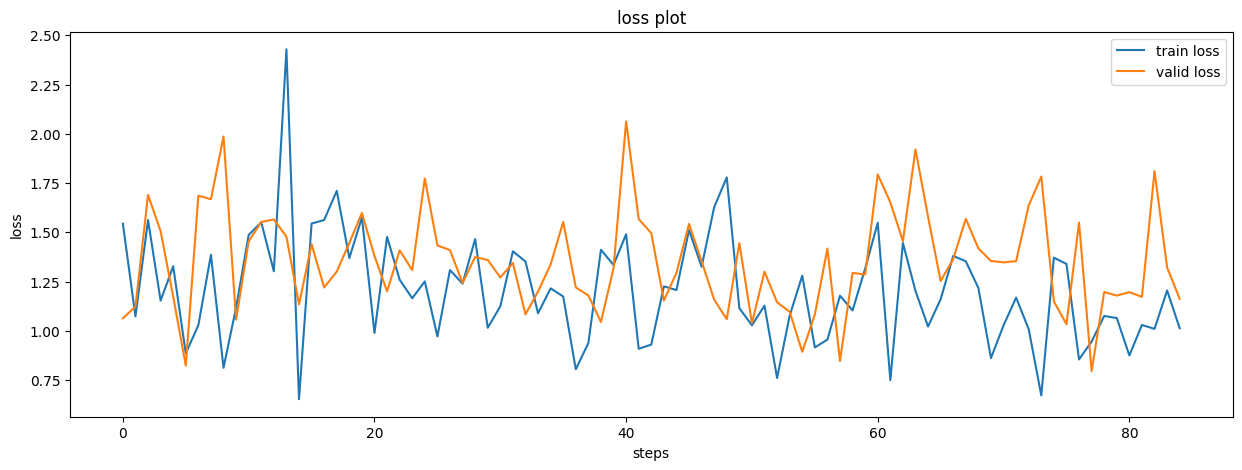

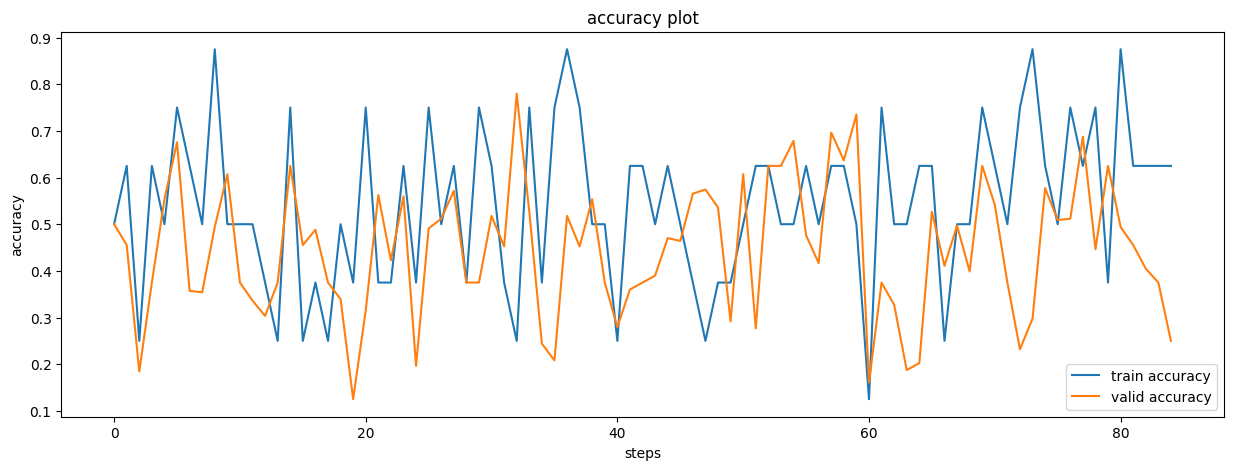

In [51]:
losses = model_trainer.losses
accuracy = model_trainer.accuracy

plot(losses, "loss", interpolate_to=len(losses["train"]))
plot(accuracy, "accuracy", interpolate_to=len(accuracy["train"]))